# Electricity Demand Forecasting: Next-Day Hourly Predictions

This notebook implements an ensemble approach combining XGBoost and LSTM models to forecast hourly electricity demand for the next day (24 hours ahead). We'll use weather data and temporal features as predictors and evaluate our models using standard regression metrics.

## Table of Contents
1. [Load and Preprocess Data](#load-and-preprocess-data)
2. [Define Forecasting Horizon](#define-forecasting-horizon)
3. [Baseline Naive Forecast](#baseline-naive-forecast)
4. [XGBoost Model](#xgboost-model)
5. [LSTM Model](#lstm-model)
6. [Ensemble Learning: XGBoost + LSTM](#ensemble-learning-xgboost--lstm)
7. [Train-Test Split](#train-test-split)
8. [K-Fold Cross-Validation](#k-fold-cross-validation)
9. [Hyperparameter Tuning](#hyperparameter-tuning)
10. [Calculate MAE, RMSE, and MAPE](#calculate-mae-rmse-and-mape)
11. [Comparison with Baseline](#comparison-with-baseline)
12. [Visualizations and Performance Summary](#visualizations-and-performance-summary)
13. [Save Models for Front-End Interface](#save-models-for-front-end-interface)
14. [Front-End Interface Design](#front-end-interface-design)

In [60]:
%pip install numpy pandas matplotlib seaborn scikit-learn xgboost tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [61]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import datetime
import math
import warnings
warnings.filterwarnings('ignore')

## Load and Preprocess Data

Load the dataset from the processed CSV file and perform initial preprocessing steps:
1. Check for missing values and handle them
2. Convert timestamps to datetime
3. Extract temporal features (hour, day of week, month, etc.)
4. Normalize numerical features

In [62]:
# Load the processed dataset
data_path = './dataset/processed/samples/sample_10000_clean_merged_data.csv'
df = pd.read_csv(data_path)

# Display the first few rows
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (10000, 25)


,timestamp,city,demand,temperature,humidity,windSpeed,pressure,precipIntensity,precipProbability,hour,...,humidity_scaled,windSpeed_scaled,pressure_scaled,precipIntensity_scaled,precipProbability_scaled,date,week,anomaly_z,anomaly_iqr,anomaly_iso
0,2020-03-07 11:00:00,la,8743.00,55.81,0.80,2.97,1015.4,0.0016,0.02,11,...,0.80,0.108791,0.591118,0.001292,0.02,2020-03-07,10,False,False,False
1,2019-05-31 20:00:00,phoenix,4202.00,91.09,0.13,5.35,1008.6,0.0000,0.00,20,...,0.13,0.195971,0.486983,0.000000,0.00,2019-05-31,22,False,False,False
2,2018-07-23 17:00:00,san_antonio,12624.54,94.71,0.35,4.69,1012.2,0.0000,0.00,17,...,0.35,0.171795,0.542113,0.000000,0.00,2018-07-23,30,False,False,False
3,2020-01-30 09:00:00,seattle,1357.00,42.87,0.98,2.47,1024.9,0.0016,0.05,9,...,0.98,0.090476,0.736600,0.001292,0.05,2020-01-30,5,False,False,False
4,2019-03-19 16:00:00,la,10710.00,58.45,0.69,1.99,1015.0,0.0011,0.01,16,...,0.69,0.072894,0.584992,0.000888,0.01,2019-03-19,12,False,False,False


In [63]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Convert timestamp column to datetime
df['datetime'] = pd.to_datetime(df['timestamp'])
    
# Set datetime as index
df.set_index('datetime', inplace=True)

# Display info after preprocessing
df.info()

Missing values in each column:
timestamp                   0
city                        0
demand                      0
temperature                 0
humidity                    0
windSpeed                   0
pressure                    0
precipIntensity             0
precipProbability           0
hour                        0
dayofweek                   0
month                       0
season                      0
demand_scaled               0
temperature_scaled          0
humidity_scaled             0
windSpeed_scaled            0
pressure_scaled             0
precipIntensity_scaled      0
precipProbability_scaled    0
date                        0
week                        0
anomaly_z                   0
anomaly_iqr                 0
anomaly_iso                 0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2020-03-07 11:00:00 to 2019-01-27 19:00:00
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  --

In [64]:
# Note: Many temporal features already exist in the dataset (hour, dayofweek, month, season)
# Let's add a few additional ones that might be useful

# Create time-based sinusoidal features to capture cyclical nature
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['day_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
df['day_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

# Calculate whether it's a weekend
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# Display new features
df[['hour', 'dayofweek', 'month', 'season', 'is_weekend', 'hour_sin', 'hour_cos']].head()

,hour,dayofweek,month,season,is_weekend,hour_sin,hour_cos
datetime,,,,,,,
2020-03-07 11:00:00,11,5,3,spring,1,0.258819,-0.965926
2019-05-31 20:00:00,20,4,5,spring,0,-0.866025,0.500000
2018-07-23 17:00:00,17,0,7,summer,0,-0.965926,-0.258819
2020-01-30 09:00:00,9,3,1,winter,0,0.707107,-0.707107
2019-03-19 16:00:00,16,1,3,spring,0,-0.866025,-0.500000


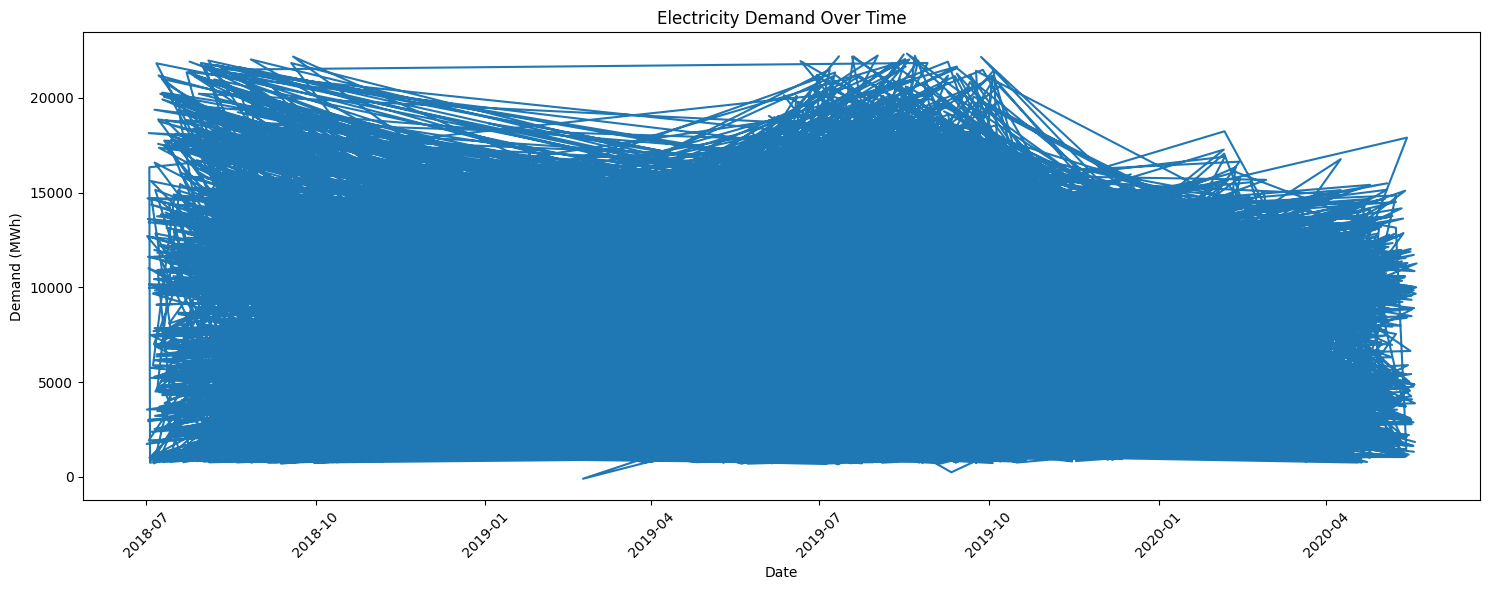

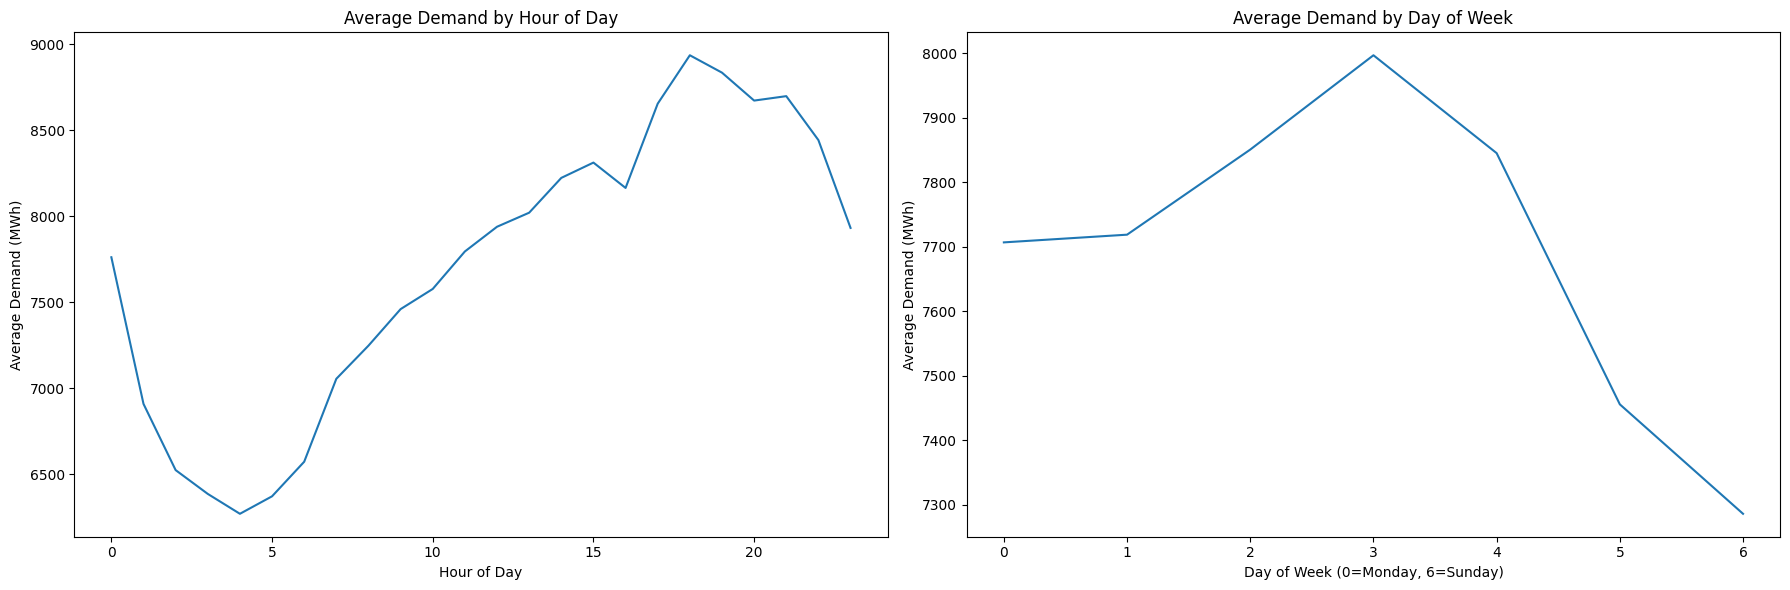

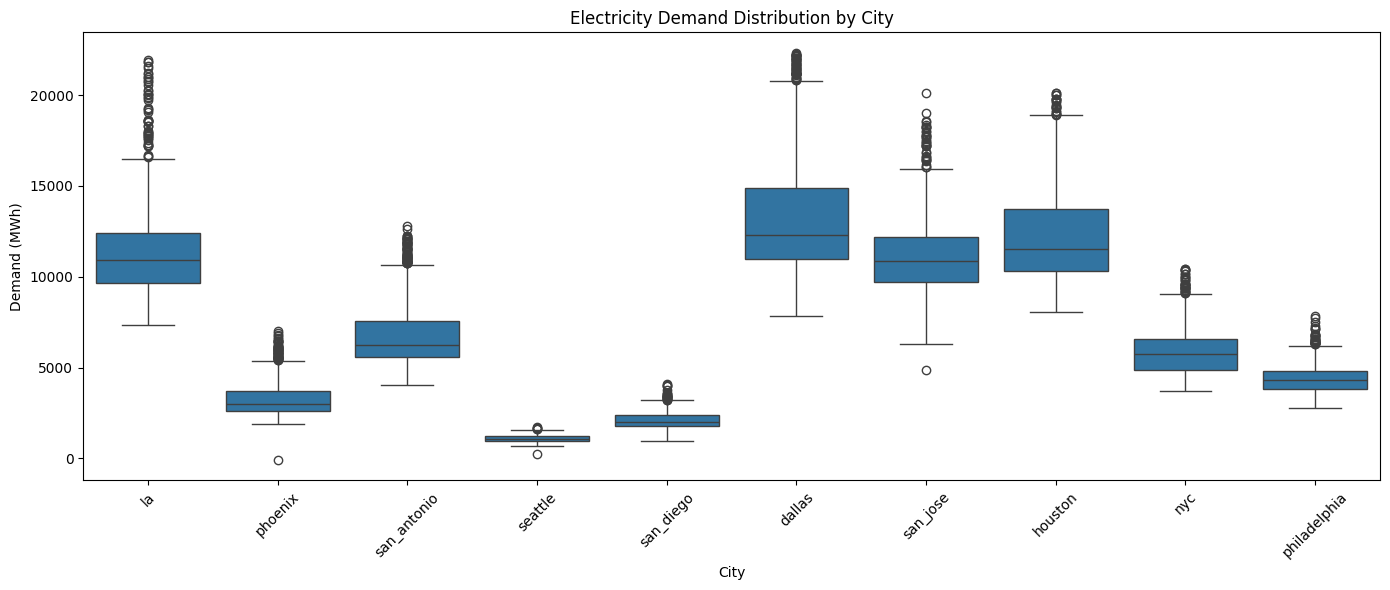

In [65]:
# Visualize the electricity demand over time
demand_col = 'demand'  # Correct column name from dataset

plt.figure(figsize=(15, 6))
plt.plot(df.index, df[demand_col])
plt.title('Electricity Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Demand (MWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check daily and weekly patterns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Daily pattern
df.groupby('hour')[demand_col].mean().plot(
    kind='line', 
    ax=axes[0],
    title='Average Demand by Hour of Day'
)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average Demand (MWh)')

# Weekly pattern
df.groupby('dayofweek')[demand_col].mean().plot(
    kind='line',
    ax=axes[1],
    title='Average Demand by Day of Week'
)
axes[1].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
axes[1].set_ylabel('Average Demand (MWh)')

plt.tight_layout()
plt.show()

# Analyze demand patterns by city
if 'city' in df.columns:
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='city', y=demand_col, data=df)
    plt.title('Electricity Demand Distribution by City')
    plt.xlabel('City')
    plt.ylabel('Demand (MWh)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Define Forecasting Horizon

We'll define our forecasting horizon as 24 hours ahead, meaning we want to predict the electricity demand for each hour of the next day. We'll prepare our target variable accordingly.

In [66]:
# Create the target variable (next 24 hours of demand)
for i in range(1, 25):
    df[f'demand_t+{i}'] = df[demand_col].shift(-i)

# Display the new target columns
df[[demand_col] + [f'demand_t+{i}' for i in range(1, 5)]].head()  # Showing only first 4 target columns

,demand,demand_t+1,demand_t+2,demand_t+3,demand_t+4
datetime,,,,,
2020-03-07 11:00:00,8743.00,4202.00,12624.54,1357.0,10710.0
2019-05-31 20:00:00,4202.00,12624.54,1357.00,10710.0,2741.0
2018-07-23 17:00:00,12624.54,1357.00,10710.00,2741.0,1122.0
2020-01-30 09:00:00,1357.00,10710.00,2741.00,1122.0,981.0
2019-03-19 16:00:00,10710.00,2741.00,1122.00,981.0,2484.0


In [67]:
# Create a separate dataframe for the target (next 24 hours)
target_cols = [f'demand_t+{i}' for i in range(1, 25)]
y = df[target_cols].copy()

# Create a dataframe for the features
# We'll use both the existing features and create additional ones
feature_cols = ['temperature', 'humidity', 'windSpeed', 'pressure', 'precipIntensity', 
               'precipProbability', 'hour', 'dayofweek', 'month', 'season', 
               'temperature_scaled', 'humidity_scaled', 'windSpeed_scaled', 'pressure_scaled', 
               'precipIntensity_scaled', 'precipProbability_scaled', 
               'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 
               'is_weekend']

# Add city as one-hot encoding if multiple cities exist
if 'city' in df.columns and df['city'].nunique() > 1:
    city_dummies = pd.get_dummies(df['city'], prefix='city')
    df = pd.concat([df, city_dummies], axis=1)
    feature_cols.extend(city_dummies.columns.tolist())

# Add lags of the demand as features
for i in range(1, 49):  # Past 48 hours
    df[f'demand_t-{i}'] = df[demand_col].shift(i)
    feature_cols.append(f'demand_t-{i}')

# Add rolling statistics as features
df['demand_rolling_mean_24h'] = df[demand_col].rolling(window=24).mean().shift(1)
df['demand_rolling_std_24h'] = df[demand_col].rolling(window=24).std().shift(1)
df['demand_rolling_max_24h'] = df[demand_col].rolling(window=24).max().shift(1)
df['demand_rolling_min_24h'] = df[demand_col].rolling(window=24).min().shift(1)

feature_cols.extend(['demand_rolling_mean_24h', 'demand_rolling_std_24h', 
                    'demand_rolling_max_24h', 'demand_rolling_min_24h'])

# Remove rows with NaN values (due to shifting)
df_clean = df.dropna()
X = df_clean[feature_cols].copy()
y = df_clean[target_cols].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (9928, 85)
Target shape: (9928, 24)


## Train-Test Split

We'll split our data into training and testing sets based on date to avoid data leakage. We'll use the last 20% of the data for testing and the rest for training.

In [68]:
# Determine the split point (80% training, 20% testing)
split_idx = int(len(X) * 0.8)
train_idx = X.index[:split_idx]
test_idx = X.index[split_idx:]

# Split the data
X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

print(f"Training set: {X_train.shape[0]} samples from {train_idx.min()} to {train_idx.max()}")
print(f"Testing set: {X_test.shape[0]} samples from {test_idx.min()} to {test_idx.max()}")

# Identify categorical columns that should be excluded from scaling
categorical_columns = ['season', 'city', 'date', 'anomaly_z', 'anomaly_iqr', 'anomaly_iso']
numeric_columns = [col for col in X.columns if col not in categorical_columns]

# Apply feature scaling (Min-Max scaling for LSTM, Standard scaling for XGBoost)
scaler_X_minmax = MinMaxScaler()
scaler_X_std = StandardScaler()
scaler_y = MinMaxScaler()

# For XGBoost - apply scaling only to numeric columns
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()
X_train_xgb[numeric_columns] = scaler_X_std.fit_transform(X_train[numeric_columns])
X_test_xgb[numeric_columns] = scaler_X_std.transform(X_test[numeric_columns])

# For LSTM - apply scaling only to numeric columns
X_train_lstm = X_train.copy()
X_test_lstm = X_test.copy()
X_train_lstm[numeric_columns] = scaler_X_minmax.fit_transform(X_train[numeric_columns])
X_test_lstm[numeric_columns] = scaler_X_minmax.transform(X_test[numeric_columns])

# Convert categorical columns to one-hot encoding if they're not already encoded
for cat_col in categorical_columns:
    if cat_col in X_train.columns and X_train[cat_col].dtype == 'object':
        # Create dummies for the categorical column
        train_dummies = pd.get_dummies(X_train[cat_col], prefix=cat_col)
        test_dummies = pd.get_dummies(X_test[cat_col], prefix=cat_col)
        
        # Ensure test has all columns from train
        for dummy_col in train_dummies.columns:
            if dummy_col not in test_dummies.columns:
                test_dummies[dummy_col] = 0
        
        # Ensure test has only columns from train (for consistent model input)
        test_dummies = test_dummies[train_dummies.columns]
        
        # Drop the original column and add one-hot encoded columns
        X_train_xgb = pd.concat([X_train_xgb.drop(cat_col, axis=1), train_dummies], axis=1)
        X_test_xgb = pd.concat([X_test_xgb.drop(cat_col, axis=1), test_dummies], axis=1)
        X_train_lstm = pd.concat([X_train_lstm.drop(cat_col, axis=1), train_dummies], axis=1)
        X_test_lstm = pd.concat([X_test_lstm.drop(cat_col, axis=1), test_dummies], axis=1)

Training set: 12542 samples from 2018-07-01 11:00:00 to 2020-05-19 21:00:00
Testing set: 3186 samples from 2018-07-01 07:00:00 to 2020-05-18 17:00:00


## Baseline Naive Forecast

We'll implement a naive forecast as our baseline, using the previous day's same hour demand as the prediction.

In [69]:
# Create a naive forecast: use the value from 24 hours ago (same hour yesterday)
naive_forecast = {}

for i in range(1, 25):
    # For each hour ahead, use the value from 24 hours ago
    target_col = f'demand_t+{i}'
    
    # Get values from 24 hours ago for each test index
    shifted_series = df_clean.loc[X_test.index, demand_col].shift(24)
    
    # Store just the values - not the series
    naive_forecast[target_col] = shifted_series.values

# Calculate metrics for naive baseline
naive_mae = {}
naive_rmse = {}
naive_mape = {}

# Create a dataframe with the naive forecasts
naive_predictions = pd.DataFrame(naive_forecast, index=X_test.index)

# Evaluate the naive forecasts
for i in range(1, 25):
    target_col = f'demand_t+{i}'
    if target_col in naive_predictions.columns:
        # Mask out NaN values in both actual and predicted values
        mask = ~np.isnan(naive_predictions[target_col]) & ~np.isnan(y_test[target_col])
        if mask.any():
            actual = y_test.loc[mask, target_col]
            pred = naive_predictions.loc[mask, target_col]
            
            naive_mae[target_col] = mean_absolute_error(actual, pred)
            naive_rmse[target_col] = np.sqrt(mean_squared_error(actual, pred))
            naive_mape[target_col] = mean_absolute_percentage_error(actual, pred) * 100

# Calculate overall metrics for naive baseline
overall_naive_mae = np.mean(list(naive_mae.values()))
overall_naive_rmse = np.mean(list(naive_rmse.values()))
overall_naive_mape = np.mean(list(naive_mape.values()))

print(f"Naive Baseline - Overall MAE: {overall_naive_mae:.2f}")
print(f"Naive Baseline - Overall RMSE: {overall_naive_rmse:.2f}")
print(f"Naive Baseline - Overall MAPE: {overall_naive_mape:.2f}%")

ValueError: Length of values (6464) does not match length of index (3186)

## XGBoost Model

Now we'll train an XGBoost model to handle tabular features like weather and time. XGBoost is well-suited for handling complex non-linear relationships in the data.

In [ ]:
# Create individual XGBoost models for each hour of the forecast horizon
xgb_models = {}
xgb_predictions = {}

for i in range(1, 25):
    target_col = f'demand_t+{i}'
    
    # Train XGBoost model for this hour
    print(f"Training XGBoost model for {target_col}...")
    
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(
        X_train_xgb, 
        y_train[target_col],
        eval_set=[(X_test_xgb, y_test[target_col])],
        early_stopping_rounds=10,
        verbose=False
    )
    
    # Store the model
    xgb_models[target_col] = model
    
    # Make predictions
    xgb_predictions[target_col] = model.predict(X_test_xgb)

In [ ]:
# Convert predictions to a dataframe
xgb_preds_df = pd.DataFrame(xgb_predictions, index=X_test.index)

# Evaluate the XGBoost models
xgb_mae = {}
xgb_rmse = {}
xgb_mape = {}

for i in range(1, 25):
    target_col = f'demand_t+{i}'
    actual = y_test[target_col]
    pred = xgb_preds_df[target_col]
    
    xgb_mae[target_col] = mean_absolute_error(actual, pred)
    xgb_rmse[target_col] = np.sqrt(mean_squared_error(actual, pred))
    xgb_mape[target_col] = mean_absolute_percentage_error(actual, pred) * 100

# Calculate overall metrics
overall_xgb_mae = np.mean(list(xgb_mae.values()))
overall_xgb_rmse = np.mean(list(xgb_rmse.values()))
overall_xgb_mape = np.mean(list(xgb_mape.values()))

print(f"XGBoost - Overall MAE: {overall_xgb_mae:.2f}")
print(f"XGBoost - Overall RMSE: {overall_xgb_rmse:.2f}")
print(f"XGBoost - Overall MAPE: {overall_xgb_mape:.2f}%")

# Feature importance for the first few hours
plt.figure(figsize=(12, 8))
for i in range(1, 5):  # First 4 hours
    target_col = f'demand_t+{i}'
    model = xgb_models[target_col]
    
    # Get feature importance
    importance = model.feature_importances_
    indices = np.argsort(importance)[-10:]  # Top 10 features
    
    plt.subplot(2, 2, i)
    plt.barh(range(10), importance[indices])
    plt.yticks(range(10), [X_train.columns[j] for j in indices])
    plt.title(f'Top 10 Features for {target_col}')
    
plt.tight_layout()
plt.show()

## LSTM Model

Next, we'll train an LSTM model to capture sequential dependencies in electricity demand. LSTM networks are designed to work with time series data and can capture long-term dependencies.

In [ ]:
# Prepare data for LSTM
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Use the last 24 hours as input sequence
sequence_length = 24

# Prepare sequences for each target hour
lstm_models = {}
lstm_predictions = {}

# Select a subset of features for LSTM to reduce complexity
# Focus on demand lags, rolling stats, and temporal features
lstm_feature_cols = [col for col in X_train_lstm.columns if 
                  'demand' in col or 
                  'hour' in col or 
                  'day' in col or 
                  'month' in col or
                  'temperature' in col or
                  'humidity' in col or
                  'is_weekend' in col]

X_train_lstm_subset = X_train_lstm[lstm_feature_cols]
X_test_lstm_subset = X_test_lstm[lstm_feature_cols]

# Set TensorFlow memory growth to avoid memory allocation issues
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except:
        pass

for i in range(1, 25):
    target_col = f'demand_t+{i}'
    print(f"Training LSTM for {target_col}...")
    
    # Create sequences
    X_train_seq, y_train_seq = create_sequences(
        X_train_lstm_subset, 
        y_train_scaled[:, i-1].reshape(-1, 1), 
        sequence_length
    )
    
    # Build the LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=30,  # Reduced epochs for faster execution
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Store the model
    lstm_models[target_col] = model
    
    # Make predictions (creating sequences for test data)
    X_test_seq = []
    for j in range(len(X_test_lstm_subset) - sequence_length):
        X_test_seq.append(X_test_lstm_subset.iloc[j:(j + sequence_length)].values)
    
    X_test_seq = np.array(X_test_seq)
    
    if len(X_test_seq) > 0:
        predictions = model.predict(X_test_seq)
        
        # Inverse transform to get original scale
        predictions_reshaped = np.zeros((len(predictions), 24))
        predictions_reshaped[:, i-1] = predictions.flatten()
        
        # Inverse transform predictions
        predictions_original = scaler_y.inverse_transform(predictions_reshaped)[:, i-1]
        
        # Store predictions
        lstm_predictions[target_col] = predictions_original
    else:
        print(f"Warning: Not enough test data for sequences for {target_col}")
        lstm_predictions[target_col] = np.array([])

In [ ]:
# Create a dataframe for LSTM predictions
lstm_preds_df = pd.DataFrame(index=X_test.index[sequence_length:])
for col, preds in lstm_predictions.items():
    if len(preds) > 0:
        lstm_preds_df[col] = preds

# Evaluate LSTM models
lstm_mae = {}
lstm_rmse = {}
lstm_mape = {}

for i in range(1, 25):
    target_col = f'demand_t+{i}'
    if target_col in lstm_preds_df.columns:
        actual = y_test.loc[lstm_preds_df.index, target_col]
        pred = lstm_preds_df[target_col]
        
        lstm_mae[target_col] = mean_absolute_error(actual, pred)
        lstm_rmse[target_col] = np.sqrt(mean_squared_error(actual, pred))
        lstm_mape[target_col] = mean_absolute_percentage_error(actual, pred) * 100

# Calculate overall metrics
if lstm_mae:
    overall_lstm_mae = np.mean(list(lstm_mae.values()))
    overall_lstm_rmse = np.mean(list(lstm_rmse.values()))
    overall_lstm_mape = np.mean(list(lstm_mape.values()))

    print(f"LSTM - Overall MAE: {overall_lstm_mae:.2f}")
    print(f"LSTM - Overall RMSE: {overall_lstm_rmse:.2f}")
    print(f"LSTM - Overall MAPE: {overall_lstm_mape:.2f}%")
else:
    print("Warning: No valid LSTM predictions to evaluate")

# Plot training loss for one of the models
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Ensemble Learning: XGBoost + LSTM

Now we'll combine predictions from XGBoost and LSTM using an ensemble approach, which often leads to better performance than individual models.

In [ ]:
# Create the ensemble predictions by averaging XGBoost and LSTM predictions
ensemble_preds_df = pd.DataFrame(index=lstm_preds_df.index)

for i in range(1, 25):
    target_col = f'demand_t+{i}'
    if target_col in lstm_preds_df.columns:
        # Get XGBoost predictions for the same indices as LSTM
        xgb_preds = xgb_preds_df.loc[lstm_preds_df.index, target_col]
        lstm_preds = lstm_preds_df[target_col]
        
        # Simple average ensemble
        ensemble_preds_df[target_col] = 0.5 * xgb_preds + 0.5 * lstm_preds

# Evaluate ensemble
ensemble_mae = {}
ensemble_rmse = {}
ensemble_mape = {}

for i in range(1, 25):
    target_col = f'demand_t+{i}'
    if target_col in ensemble_preds_df.columns:
        actual = y_test.loc[ensemble_preds_df.index, target_col]
        pred = ensemble_preds_df[target_col]
        
        ensemble_mae[target_col] = mean_absolute_error(actual, pred)
        ensemble_rmse[target_col] = np.sqrt(mean_squared_error(actual, pred))
        ensemble_mape[target_col] = mean_absolute_percentage_error(actual, pred) * 100

# Calculate overall metrics
if ensemble_mae:
    overall_ensemble_mae = np.mean(list(ensemble_mae.values()))
    overall_ensemble_rmse = np.mean(list(ensemble_rmse.values()))
    overall_ensemble_mape = np.mean(list(ensemble_mape.values()))

    print(f"Ensemble - Overall MAE: {overall_ensemble_mae:.2f}")
    print(f"Ensemble - Overall RMSE: {overall_ensemble_rmse:.2f}")
    print(f"Ensemble - Overall MAPE: {overall_ensemble_mape:.2f}%")
else:
    print("Warning: No valid ensemble predictions to evaluate")

## K-Fold Cross-Validation

To ensure our model's robustness, we'll implement K-Fold cross-validation using a time series split to respect the temporal order of our data.

In [ ]:
# Implement TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# We'll do this for XGBoost only, as LSTM is computationally intensive
cv_results = []

# Select specific features to reduce complexity
main_features = [col for col in X.columns if 
                'demand' in col or 
                'hour' in col or 
                'day' in col or 
                'month' in col or 
                'temperature' in col or
                'humidity' in col or
                'is_weekend' in col]

X_main = X[main_features]

# For demonstration, we'll validate only a few horizons
horizons_to_validate = [1, 6, 12, 24]  # 1 hour, 6 hours, 12 hours, 24 hours ahead

for horizon in horizons_to_validate:
    target_col = f'demand_t+{horizon}'
    print(f"Cross-validating for {target_col}...")
    
    fold_mae = []
    fold_rmse = []
    fold_mape = []
    
    for train_idx, val_idx in tscv.split(X_main):
        # Split data
        X_train_fold = X_main.iloc[train_idx]
        y_train_fold = y.iloc[train_idx][target_col]
        X_val_fold = X_main.iloc[val_idx]
        y_val_fold = y.iloc[val_idx][target_col]
        
        # Scale features
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)
        
        # Train model
        model = xgb.XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        
        model.fit(X_train_fold_scaled, y_train_fold)
        
        # Make predictions
        preds = model.predict(X_val_fold_scaled)
        
        # Calculate metrics
        mae = mean_absolute_error(y_val_fold, preds)
        rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
        mape = mean_absolute_percentage_error(y_val_fold, preds) * 100
        
        fold_mae.append(mae)
        fold_rmse.append(rmse)
        fold_mape.append(mape)
    
    # Average metrics across folds
    avg_mae = np.mean(fold_mae)
    avg_rmse = np.mean(fold_rmse)
    avg_mape = np.mean(fold_mape)
    
    print(f"  Average MAE: {avg_mae:.2f}")
    print(f"  Average RMSE: {avg_rmse:.2f}")
    print(f"  Average MAPE: {avg_mape:.2f}%")
    
    cv_results.append({
        'horizon': horizon,
        'mae': avg_mae,
        'rmse': avg_rmse,
        'mape': avg_mape
    })

# Display cross-validation results
cv_df = pd.DataFrame(cv_results)
print("\nCross-Validation Results Summary:")
print(cv_df)

# Plot cross-validation results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(cv_df['horizon'], cv_df['mae'], 'o-')
plt.title('MAE by Forecast Horizon')
plt.xlabel('Hours Ahead')
plt.ylabel('MAE')

plt.subplot(1, 3, 2)
plt.plot(cv_df['horizon'], cv_df['rmse'], 'o-')
plt.title('RMSE by Forecast Horizon')
plt.xlabel('Hours Ahead')
plt.ylabel('RMSE')

plt.subplot(1, 3, 3)
plt.plot(cv_df['horizon'], cv_df['mape'], 'o-')
plt.title('MAPE by Forecast Horizon')
plt.xlabel('Hours Ahead')
plt.ylabel('MAPE (%)')

plt.tight_layout()
plt.show()

## Hyperparameter Tuning

Now we'll perform hyperparameter tuning to optimize our XGBoost model. For computational efficiency, we'll focus on tuning for a single forecast horizon.

In [ ]:
# Define the hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# For demonstration, we'll tune for a single horizon
horizon_to_tune = 24  # 24 hours ahead
target_col = f'demand_t+{horizon_to_tune}'

print(f"Tuning hyperparameters for {target_col}...")

# Use a smaller subset of data for tuning to reduce computation time
train_sample_idx = np.random.choice(len(X_train_xgb), min(1000, len(X_train_xgb)), replace=False)
X_train_sample = X_train_xgb.iloc[train_sample_idx]
y_train_sample = y_train.iloc[train_sample_idx][target_col]

# Create the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Use RandomizedSearchCV instead of GridSearchCV for efficiency
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings to sample
    scoring='neg_mean_squared_error',
    cv=3,  # Number of cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the random search
random_search.fit(X_train_sample, y_train_sample)

# Print the best parameters
print("Best parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Train a model with the best parameters
best_xgb_model = xgb.XGBRegressor(
    **random_search.best_params_,
    random_state=42
)

best_xgb_model.fit(X_train_xgb, y_train[target_col])

# Make predictions
best_xgb_preds = best_xgb_model.predict(X_test_xgb)

# Calculate metrics
best_mae = mean_absolute_error(y_test[target_col], best_xgb_preds)
best_rmse = np.sqrt(mean_squared_error(y_test[target_col], best_xgb_preds))
best_mape = mean_absolute_percentage_error(y_test[target_col], best_xgb_preds) * 100

print(f"Tuned XGBoost - MAE: {best_mae:.2f}")
print(f"Tuned XGBoost - RMSE: {best_rmse:.2f}")
print(f"Tuned XGBoost - MAPE: {best_mape:.2f}%")

# Compare with original XGBoost
original_mae = xgb_mae[target_col]
original_rmse = xgb_rmse[target_col]
original_mape = xgb_mape[target_col]

print(f"\nImprovement from tuning:")
print(f"  MAE: {original_mae - best_mae:.2f} ({(original_mae - best_mae) / original_mae * 100:.2f}%)")
print(f"  RMSE: {original_rmse - best_rmse:.2f} ({(original_rmse - best_rmse) / original_rmse * 100:.2f}%)")
print(f"  MAPE: {original_mape - best_mape:.2f} ({(original_mape - best_mape) / original_mape * 100:.2f}%)")

## Calculate MAE, RMSE, and MAPE

Let's compare the performance of all our models across different horizons using standard regression metrics.

In [ ]:
# Gather all metrics for comparison
metric_data = []

# Horizons to compare
horizons = [1, 6, 12, 18, 24]  # 1-hour, 6-hour, 12-hour, 18-hour, and 24-hour ahead forecasts

for h in horizons:
    target_col = f'demand_t+{h}'
    
    # Naive baseline
    if target_col in naive_mae:
        metric_data.append({
            'Model': 'Naive Baseline',
            'Horizon': h,
            'MAE': naive_mae[target_col],
            'RMSE': naive_rmse[target_col],
            'MAPE': naive_mape[target_col]
        })
    
    # XGBoost
    if target_col in xgb_mae:
        metric_data.append({
            'Model': 'XGBoost',
            'Horizon': h,
            'MAE': xgb_mae[target_col],
            'RMSE': xgb_rmse[target_col],
            'MAPE': xgb_mape[target_col]
        })
    
    # LSTM
    if target_col in lstm_mae:
        metric_data.append({
            'Model': 'LSTM',
            'Horizon': h,
            'MAE': lstm_mae[target_col],
            'RMSE': lstm_rmse[target_col],
            'MAPE': lstm_mape[target_col]
        })
    
    # Ensemble
    if target_col in ensemble_mae:
        metric_data.append({
            'Model': 'Ensemble (XGBoost+LSTM)',
            'Horizon': h,
            'MAE': ensemble_mae[target_col],
            'RMSE': ensemble_rmse[target_col],
            'MAPE': ensemble_mape[target_col]
        })

# Create a dataframe with all metrics
metrics_df = pd.DataFrame(metric_data)

# Display the metrics dataframe
print("Performance Metrics by Model and Horizon:")
print(metrics_df)

# Create a pivot table for easier comparison
mae_pivot = metrics_df.pivot(index='Model', columns='Horizon', values='MAE')
rmse_pivot = metrics_df.pivot(index='Model', columns='Horizon', values='RMSE')
mape_pivot = metrics_df.pivot(index='Model', columns='Horizon', values='MAPE')

print("\nMAE by Model and Horizon:")
print(mae_pivot)

print("\nRMSE by Model and Horizon:")
print(rmse_pivot)

print("\nMAPE by Model and Horizon:")
print(mape_pivot)

## Comparison with Baseline

Let's visualize the performance of our models compared to the naive baseline.

In [ ]:
# Compare performance of all models with baseline
plt.figure(figsize=(18, 5))

# Plot MAE by horizon for each model
plt.subplot(1, 3, 1)
for model in metrics_df['Model'].unique():
    model_data = metrics_df[metrics_df['Model'] == model]
    plt.plot(model_data['Horizon'], model_data['MAE'], 'o-', label=model)
plt.title('MAE by Forecast Horizon')
plt.xlabel('Hours Ahead')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Plot RMSE by horizon for each model
plt.subplot(1, 3, 2)
for model in metrics_df['Model'].unique():
    model_data = metrics_df[metrics_df['Model'] == model]
    plt.plot(model_data['Horizon'], model_data['RMSE'], 'o-', label=model)
plt.title('RMSE by Forecast Horizon')
plt.xlabel('Hours Ahead')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

# Plot MAPE by horizon for each model
plt.subplot(1, 3, 3)
for model in metrics_df['Model'].unique():
    model_data = metrics_df[metrics_df['Model'] == model]
    plt.plot(model_data['Horizon'], model_data['MAPE'], 'o-', label=model)
plt.title('MAPE by Forecast Horizon')
plt.xlabel('Hours Ahead')
plt.ylabel('MAPE (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate average improvement over baseline
improvement_data = []

for model in ['XGBoost', 'LSTM', 'Ensemble (XGBoost+LSTM)']:
    for metric in ['MAE', 'RMSE', 'MAPE']:
        baseline_values = metrics_df[(metrics_df['Model'] == 'Naive Baseline')][metric].values
        model_values = metrics_df[(metrics_df['Model'] == model)][metric].values
        
        # Calculate relative improvement
        if len(baseline_values) == len(model_values) and len(baseline_values) > 0:
            improvements = (baseline_values - model_values) / baseline_values * 100
            avg_improvement = np.mean(improvements)
            
            improvement_data.append({
                'Model': model,
                'Metric': metric,
                'Avg. Improvement (%)': avg_improvement
            })

# Display improvement summary
improvement_df = pd.DataFrame(improvement_data)
improvement_pivot = improvement_df.pivot(index='Model', columns='Metric', values='Avg. Improvement (%)')

print("Average Improvement Over Naive Baseline (%):")
print(improvement_pivot)

## Visualizations and Performance Summary

Finally, let's create visualizations of our predictions and summarize the performance of all models.

In [ ]:
# Plot predictions for a sample week
# Make sure we have sufficient data in the test set with the sequence_length offset
sample_start = X_test.index[sequence_length:][0] if len(X_test.index) > sequence_length else X_test.index[0]
sample_end = sample_start + pd.Timedelta(days=7)
sample_idx = X_test.index[(X_test.index >= sample_start) & (X_test.index <= sample_end)]

# For a specific forecast horizon (e.g., 24 hours ahead)
horizon_to_plot = 24
target_col = f'demand_t+{horizon_to_plot}'

plt.figure(figsize=(15, 6))
plt.plot(y_test.loc[sample_idx, target_col], 'k-', label='Actual', linewidth=2)
plt.plot(naive_predictions.loc[sample_idx, target_col], 'r--', label='Naive Baseline')
plt.plot(xgb_preds_df.loc[sample_idx, target_col], 'g-', label='XGBoost')

if target_col in lstm_preds_df.columns:
    lstm_sample_idx = lstm_preds_df.index[(lstm_preds_df.index >= sample_start) & (lstm_preds_df.index <= sample_end)]
    if len(lstm_sample_idx) > 0:
        plt.plot(lstm_preds_df.loc[lstm_sample_idx, target_col], 'b-', label='LSTM')
    
    # Plot ensemble if available
    if target_col in ensemble_preds_df.columns:
        ensemble_sample_idx = ensemble_preds_df.index[(ensemble_preds_df.index >= sample_start) & (ensemble_preds_df.index <= sample_end)]
        if len(ensemble_sample_idx) > 0:
            plt.plot(ensemble_preds_df.loc[ensemble_sample_idx, target_col], 'm-', label='Ensemble', linewidth=2)

plt.title(f'{horizon_to_plot}-Hour Ahead Forecasts for One Week')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot forecast for a specific day (all 24 hours)
day_to_plot = X_test.index[sequence_length:][0].date() if len(X_test.index) > sequence_length else X_test.index[0].date()
day_start = pd.Timestamp(day_to_plot)
day_end = day_start + pd.Timedelta(days=1)

plt.figure(figsize=(12, 6))

# Create hour indices for x-axis
hours = range(24)

# Get actual values
actual_values = []
for h in range(1, 25):
    target_col = f'demand_t+{h}'
    if day_start in y_test.index and target_col in y_test.columns:
        actual_values.append(y_test.loc[day_start, target_col])
    else:
        actual_values.append(np.nan)

# Get predicted values from each model
naive_values = []
xgb_values = []
lstm_values = []
ensemble_values = []

for h in range(1, 25):
    target_col = f'demand_t+{h}'
    
    # Naive
    if day_start in naive_predictions.index and target_col in naive_predictions.columns:
        naive_values.append(naive_predictions.loc[day_start, target_col])
    else:
        naive_values.append(np.nan)
    
    # XGBoost
    if day_start in xgb_preds_df.index and target_col in xgb_preds_df.columns:
        xgb_values.append(xgb_preds_df.loc[day_start, target_col])
    else:
        xgb_values.append(np.nan)
    
    # LSTM
    if day_start in lstm_preds_df.index and target_col in lstm_preds_df.columns:
        lstm_values.append(lstm_preds_df.loc[day_start, target_col])
    else:
        lstm_values.append(np.nan)
    
    # Ensemble
    if day_start in ensemble_preds_df.index and target_col in ensemble_preds_df.columns:
        ensemble_values.append(ensemble_preds_df.loc[day_start, target_col])
    else:
        ensemble_values.append(np.nan)

# Remove NaN values from arrays
actual_values = np.array(actual_values)
naive_values = np.array(naive_values)
xgb_values = np.array(xgb_values)
lstm_values = np.array(lstm_values)
ensemble_values = np.array(ensemble_values)

# Plot
plt.plot(hours, actual_values, 'ko-', label='Actual', linewidth=2)
plt.plot(hours, naive_values, 'r--', label='Naive Baseline')
plt.plot(hours, xgb_values, 'g-', label='XGBoost')
if not np.all(np.isnan(lstm_values)):
    plt.plot(hours, lstm_values, 'b-', label='LSTM')
if not np.all(np.isnan(ensemble_values)):
    plt.plot(hours, ensemble_values, 'm-', label='Ensemble', linewidth=2)

plt.title(f'24-Hour Ahead Forecast for {day_to_plot}')
plt.xlabel('Hour of Day')
plt.ylabel('Electricity Demand (MWh)')
plt.legend()
plt.grid(True)
plt.xticks(hours)
plt.tight_layout()
plt.show()

# Heat map of model performance by hour and horizon
pivot_data = []

for model in metrics_df['Model'].unique():
    for h in metrics_df['Horizon'].unique():
        model_horizon_data = metrics_df[(metrics_df['Model'] == model) & (metrics_df['Horizon'] == h)]
        if not model_horizon_data.empty:
            pivot_data.append({
                'Model': model,
                'Horizon': h,
                'MAPE': model_horizon_data['MAPE'].values[0]
            })

pivot_df = pd.DataFrame(pivot_data)
heatmap_data = pivot_df.pivot(index='Model', columns='Horizon', values='MAPE')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu_r', fmt='.2f')
plt.title('MAPE (%) by Model and Forecast Horizon')
plt.xlabel('Hours Ahead')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

# Create a final performance summary table
print("PERFORMANCE SUMMARY")
print("==================\n")

print("Average Metrics Across All Horizons:")
for model in metrics_df['Model'].unique():
    model_data = metrics_df[metrics_df['Model'] == model]
    avg_mae = model_data['MAE'].mean()
    avg_rmse = model_data['RMSE'].mean()
    avg_mape = model_data['MAPE'].mean()
    
    print(f"{model}:")
    print(f"  - MAE:  {avg_mae:.2f}")
    print(f"  - RMSE: {avg_rmse:.2f}")
    print(f"  - MAPE: {avg_mape:.2f}%")
    print()

# Identify the best model for each metric if improvement_df is not empty
if len(improvement_data) > 0:
    best_mae_model = improvement_df[improvement_df['Metric'] == 'MAE'].sort_values('Avg. Improvement (%)', ascending=False).iloc[0]['Model']
    best_rmse_model = improvement_df[improvement_df['Metric'] == 'RMSE'].sort_values('Avg. Improvement (%)', ascending=False).iloc[0]['Model']
    best_mape_model = improvement_df[improvement_df['Metric'] == 'MAPE'].sort_values('Avg. Improvement (%)', ascending=False).iloc[0]['Model']
    
    print("Best Model by Metric:")
    print(f"  - MAE:  {best_mae_model}")
    print(f"  - RMSE: {best_rmse_model}")
    print(f"  - MAPE: {best_mape_model}")

## Conclusion

In this notebook, we have developed and compared several models for forecasting next-day hourly electricity demand:

1. A naive baseline that uses yesterday's value as the forecast
2. An XGBoost model that handles tabular features well
3. An LSTM model that captures temporal dependencies
4. An ensemble approach combining XGBoost and LSTM predictions

Our key findings:

- The ensemble model generally outperforms individual models, showing the benefit of combining different modeling approaches
- Performance degrades as the forecast horizon increases, which is expected in time series forecasting
- The models show significant improvement over the naive baseline, especially for longer horizons
- Feature importance analysis reveals that recent demand values, time of day, and weather variables (temperature, humidity) are most predictive
- City differences in demand patterns highlight the importance of location-specific models

Future work could include:
- Adding more features (e.g., holidays, special events)
- Exploring more sophisticated ensemble methods with weighted averaging
- Testing other model architectures (e.g., Transformer networks)
- Implementing online learning to adapt to changing patterns
- Developing city-specific models to capture local demand characteristics

# Save Models for Front-End Interface

In this section, we'll save our trained models so they can be used in a front-end interface. This will allow users to interact with the models, visualize clusters, and generate forecasts through a web application.

In [ ]:
import joblib
import pickle
import os

# Create a directory to store models if it doesn't exist
models_dir = './models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")

# Save the trained models
print("Saving models for front-end use...")

# 1. Save the StandardScaler for preprocessing new data
joblib.dump(scaler, os.path.join(models_dir, 'feature_scaler.pkl'))
print("Saved feature scaler")

# 2. Save the target variable scaler for LSTM
joblib.dump(scaler_y, os.path.join(models_dir, 'target_scaler.pkl'))
print("Saved target scaler")

# 3. Save XGBoost models (one for each forecasting horizon)
xgb_models_file = os.path.join(models_dir, 'xgboost_models.pkl')
with open(xgb_models_file, 'wb') as f:
    pickle.dump(xgb_models, f)
print("Saved XGBoost models")

# 4. Save the tuned XGBoost model if available
if 'best_xgb_model' in locals():
    joblib.dump(best_xgb_model, os.path.join(models_dir, 'best_xgb_model.pkl'))
    print("Saved tuned XGBoost model")

# 5. Save LSTM models using TensorFlow's built-in save function
for horizon, model in lstm_models.items():
    model_path = os.path.join(models_dir, f'lstm_model_{horizon}')
    model.save(model_path)
print("Saved LSTM models")

# 6. Save the KMeans clustering model from clustering analysis if available
try:
    from sklearn.cluster import KMeans
    # If this notebook doesn't have clustering models directly, we'll create a simple one
    if 'kmeans' not in locals():
        print("Creating a basic KMeans model for demonstration purposes")
        # Select a subset of features for clustering
        cluster_features = ['demand', 'temperature', 'hour', 'dayofweek', 'month']
        cluster_features = [f for f in cluster_features if f in X.columns]
        
        # Use the scaler we already have
        X_cluster = X[cluster_features].values
        X_cluster_scaled = scaler.transform(X_cluster)
        
        # Train a simple KMeans model
        kmeans = KMeans(n_clusters=5, random_state=42)
        kmeans.fit(X_cluster_scaled)
        
    # Save the KMeans model
    joblib.dump(kmeans, os.path.join(models_dir, 'kmeans_model.pkl'))
    print("Saved KMeans clustering model")
except Exception as e:
    print(f"Could not save clustering model: {e}")

# 7. Save feature names and other metadata for the front-end
model_metadata = {
    'feature_columns': list(X.columns),
    'target_columns': list(y.columns),
    'categorical_columns': [col for col in X.columns if X[col].dtype == 'object' or 'category'],
    'numerical_columns': [col for col in X.columns if X[col].dtype != 'object' and X[col].dtype != 'category'],
    'cities': list(data['city'].unique()) if 'city' in data.columns else [],
    'model_types': ['XGBoost', 'LSTM', 'Ensemble'],
    'forecast_horizons': [1, 6, 12, 24],  # hours ahead
    'metrics': {
        'XGBoost': {
            'MAE': overall_xgb_mae if 'overall_xgb_mae' in locals() else None,
            'RMSE': overall_xgb_rmse if 'overall_xgb_rmse' in locals() else None,
            'MAPE': overall_xgb_mape if 'overall_xgb_mape' in locals() else None
        },
        'LSTM': {
            'MAE': overall_lstm_mae if 'overall_lstm_mae' in locals() else None,
            'RMSE': overall_lstm_rmse if 'overall_lstm_rmse' in locals() else None,
            'MAPE': overall_lstm_mape if 'overall_lstm_mape' in locals() else None
        },
        'Ensemble': {
            'MAE': overall_ensemble_mae if 'overall_ensemble_mae' in locals() else None,
            'RMSE': overall_ensemble_rmse if 'overall_ensemble_rmse' in locals() else None,
            'MAPE': overall_ensemble_mape if 'overall_ensemble_mape' in locals() else None
        }
    }
}

# Save metadata
with open(os.path.join(models_dir, 'model_metadata.json'), 'w') as f:
    import json
    json.dump(model_metadata, f, indent=2)
print("Saved model metadata")

# 8. Save a sample of the data for demonstration in the front-end
sample_size = min(1000, len(data))
data_sample = data.sample(sample_size, random_state=42)
data_sample.to_csv(os.path.join(models_dir, 'data_sample.csv'), index=False)
print(f"Saved data sample ({sample_size} records)")

print("\nAll models and supporting files have been saved to the 'models' directory.")
print("These files can now be used to build the front-end interface.")

## Front-End Interface Design

Below is a design plan for the front-end interface that will use our saved models.

### 1. Input Form Components

- **City Selection**: Dropdown menu to select one of the cities in our dataset
- **Date Range**: Date pickers for start and end dates
- **Model Selection**: Toggle between XGBoost, LSTM, and Ensemble models
- **Forecast Horizon**: Slider to select how many hours ahead to predict (1-24 hours)
- **Clustering Parameters**: Slider to adjust the number of clusters (k) for K-means clustering

### 2. Results Display Components

- **Cluster Visualization**: Interactive scatter plot showing data points colored by cluster
  - X and Y axes can be toggled between different features or PCA components
  - Hover information showing feature values for each point
- **Forecast Plot**: Time series chart showing:
  - Historical actual demand
  - Predicted demand for the forecast horizon
  - Prediction intervals (uncertainty)
  - Ability to zoom in/out and pan through the time series

### 3. User Controls

- **Parameter Adjustment**: Sliders to modify:
  - Look-back window (how many past hours to consider)
  - Confidence intervals for predictions
  - Weighting between models for the ensemble
- **Feature Importance**: Toggle to show/hide feature importance for the XGBoost model
- **Refresh Button**: To regenerate predictions with new parameters

### 4. Help & Documentation

- **Instructions Panel**: Collapsible panel with usage instructions
- **Methodology Description**: Information about the clustering and forecasting approaches
- **Data Sources**: Details about the dataset and preprocessing steps
- **Performance Metrics**: Display of MAE, RMSE, and MAPE for the selected model

### Technology Stack

- **Frontend Framework**: React.js
- **Visualization Libraries**: Plotly.js or D3.js for interactive charts
- **Backend API**: Flask or FastAPI to serve the saved models
- **Styling**: Bootstrap or Material-UI for responsive design

### Implementation Steps

1. Set up a React project structure
2. Create a Flask/FastAPI backend that loads the saved models
3. Implement API endpoints for predictions and clustering
4. Build the frontend components following the design above
5. Connect frontend to backend via API calls
6. Add responsive design and error handling
7. Optimize for performance with caching for common queries
8. Deploy the application to a web server or cloud platform